[View in Colaboratory](https://colab.research.google.com/github/the-osprey/neural_nets/blob/master/NN_concept_implementation.ipynb)

## Introduction

This is just a basic implementation of a neural net. Instead of using TensorFlow or Caffe, the goal is to implement the basic mathematical functionality of one by hand. Of course, this won't be the fastest or most efficient network by any means. Rather, it's just a matter of demonstrating fundamental ideas. 

## Data generation

I'll use some basic Python to create a dataset that is not easily linearly sererable. A spiral is a pretty classic dataset, which I do below

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid", 
        color_codes = True,
        font_scale = 1.5)

In [0]:
N = 500 # number of data points
D = 2 # dimensionality
K = 3 # number of classes
reg = 1e-3
step_size = 1e-0


X = np.zeros((N*K, D)) # N*KxD data matrix where each row is a single example
y = np.zeros(N*K, dtype='uint8') # label each class

for j in range(K):
  ix = range(N*j, N*(j+1))
  radius = np.linspace(0.0, 1, N) 
  theta = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
  X[ix] = np.c_[radius*np.sin(theta), radius*np.cos(theta)]
  y[ix] = j


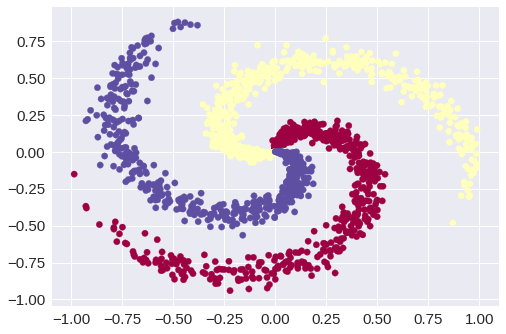

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

Note we don't need to preprocess the data since it is centered and normalized! #blessed

# Let's train a softmax linear classifier

Note the code below is for demonstative purposes. A model is put together after this walkthrough

In [0]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

In [0]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

We now need a loss function. With softmax, we use cross-entropy loss. Thus, the softmax classifier computes loss as:

$$ L_i = -\log(\frac{e^{f_{y_i}}}{\sum_je^{f_j}})$$

Remember that the softmax classifier interprets every element of $f$ as holding log probabilities of the three classes. By exponentiating and then normalizing, we get the normalized probability of the correct class within the $\log$ expression. 

We should also introduce a regularization term to prevent overfitting. In our case, we will use $L2$ regularization. Additionally, recall that the full softmax classifier is just defined as the average cross-entropy loss over all the training examples. Thus, our total loss is:

$$L = \frac{1}{N}\sum_i L_i + \frac{1}{2} \sum_k \sum_l W^2_{k,l}$$

So, given the array of `scores`, we can compute our loss below:

In [0]:
num_examples = X.shape[0]
exp_scores = np.exp(scores) # get unnormalized probabilities aka numerator
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # normalize them (denominator)
# now we have an array that is 1500 X 3 where each row contains the class probabilities. 

logprobs = -np.log(probs[range(num_examples),y])
# This is a 1-d array of probabilities assigned to the correct classes for each example

In [7]:
# Now compute the average cross-entropy loss and regularization
data_loss = np.sum(logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss
print(loss)

1.0978948282482348


We get a loss of 1.09, which makes sense since this is just np.log(1.0 / 3)

Now let's compute the gradient with backpropogation

We'll use basic gradient descent. We start with random parameters (as set above) and then evaluate the gradient of the loss function wrt the parameters. First, let $p$ be an intermediate variable for the inside of the $\log$ in the softmax function. Thus, we get

$$ p_k = \frac{e^{f_k}}{\sum_j e^{f_j}}$$ $$L_i = -\log(p_{y_i}) $$

Now, we just use some basic calculus to compute $\frac{\partial L_i}{\partial f_k}$. This gets:
$$\frac{\partial L_i}{\partial f_k} = p_k(y_i=k)$$

This is a great expression that condenses to the following code:

In [0]:
grad_score = probs
grad_score[range(num_examples),y] -= 1
grad_score /= num_examples

Now we can backpropogate into `W` and `b`

In [0]:
dW = np.dot(X.T, grad_score)
db = np.sum(grad_score, axis=0, keepdims=True)
dW += reg*W # also need to take gradient on regularization term

After performing the gradient, we need to perform a parameter udpate still:


In [0]:
W += -step_size * dW
b += -step_size * db

# Training our softmax classifier

In [11]:
# hyperparameters
step_size = 1e-0
reg = 1e-3

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# conduct gradient descent with the following loop
num_examples = X.shape[0]
for i in range(200):
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute probabilites via softmax
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # Get avg cross-entropy loss w regularization
  logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))
    
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db


iteration 0: loss 1.094498
iteration 10: loss 0.901419
iteration 20: loss 0.829258
iteration 30: loss 0.796305
iteration 40: loss 0.779042
iteration 50: loss 0.769140
iteration 60: loss 0.763092
iteration 70: loss 0.759229
iteration 80: loss 0.756676
iteration 90: loss 0.754945
iteration 100: loss 0.753747
iteration 110: loss 0.752905
iteration 120: loss 0.752304
iteration 130: loss 0.751872
iteration 140: loss 0.751557
iteration 150: loss 0.751327
iteration 160: loss 0.751157
iteration 170: loss 0.751032
iteration 180: loss 0.750938
iteration 190: loss 0.750868


In [12]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.52


Well, that's not too great. But it makes sense since we use a *linear* classifier. A graph reveals just that:

(-1.9402882600966591, 1.8597117399033443)

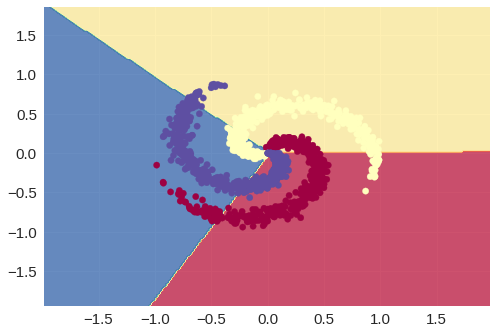

In [13]:
# plot the classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Train a Neural Network

It's pretty obvious a linear classifier won't work with a linear classifier. Thus, a nueral network with one hidden layer probably does a good job with this dataset. Below I highlight some changes, then implement it later on. 

In [0]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

In [0]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # ReLU activation
scores = np.dot(hidden_layer, W2) + b2

Below we do backpropogation once again, however we need to go through the second later, and then the first. 


In [0]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

# hidden layer gradient
dhidden = np.dot(dscores, W2.T)


Now we have to backpropogate the ReLU non-linearity. This actually isnt so hards since $relu = \max(0, x)$ and $\frac{dr}{dx} = 1 $ if $x>0$

In [0]:
# ReLU backprop
dhidden[hidden_layer <= 0] = 0

# do final backprop of first layer into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

That's it! Everything else remains unchanged. So, the code now is...

# Neural Network Trainer

In [18]:
# initialize parameters randomly
h = 120 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098696
iteration 1000: loss 0.288210
iteration 2000: loss 0.260290
iteration 3000: loss 0.248332
iteration 4000: loss 0.245703
iteration 5000: loss 0.244987
iteration 6000: loss 0.244389
iteration 7000: loss 0.244169
iteration 8000: loss 0.244061
iteration 9000: loss 0.243996


In [19]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


(-1.9402882600966591, 1.8597117399033443)

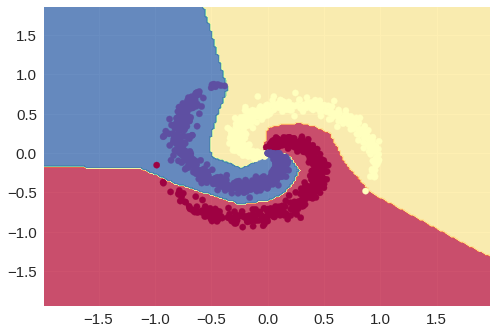

In [20]:

# plot the classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())